# Turn GSM-Speech Channel into File-Transferring Channel

# Abstract: 
>This project is aiming to modify the regular GSM-Speech Channel to operate as File-Transferring Channel. We described this new concept with an actual experiment by successfully transferring a message between two laptops using this channel.
The achieved data-rate was low (100 bits/s), but with the right techniques this rate can be increased significantly.

# First:
>You need to connect your phone with a laptop using the 3.5mm jack socket
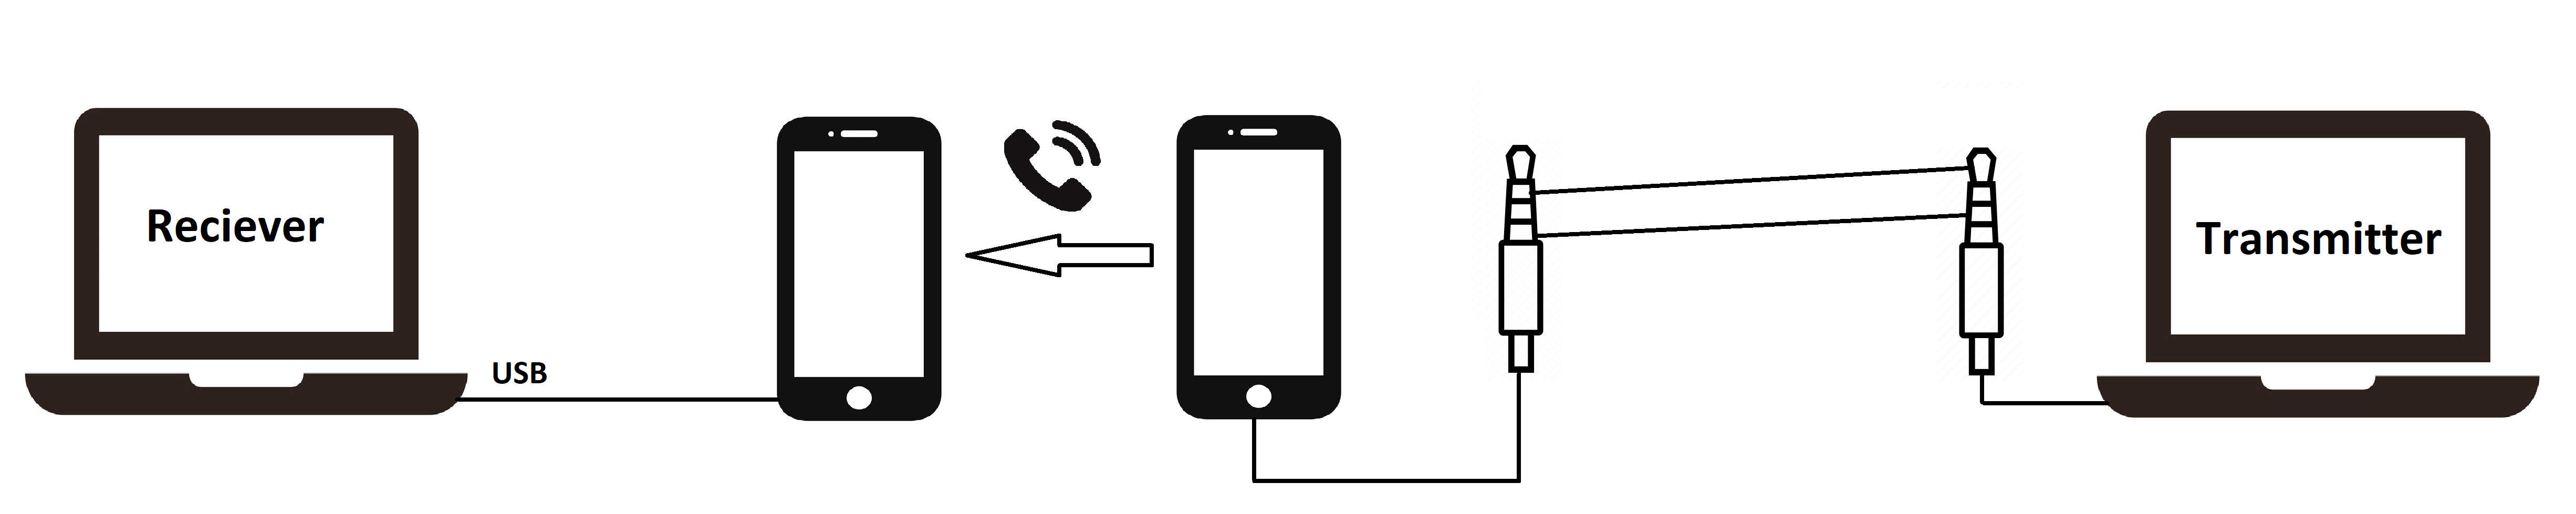

### 
## SENDING:

In [ ]:
#First import the used libraries

import wavio
from scipy.io.wavfile import read
import numpy as np
import matplotlib.pyplot as plt
import moviepy.editor as me
import re
import sys
import math
np.set_printoptions(threshold=sys.maxsize)

# Create the message and convert it to binary "msg_bin"

message='described this channel'
message='XXXX'+message+'YYYY'
msg_bin=''.join(format(ord(i),'08b') for i in message)
x=msg_bin
msg_bin=list(msg_bin)
msg_bin=[int(numeric_string) for numeric_string in msg_bin]
msg_bin=np.array(msg_bin)

###############################################################################################

# Generate "audio_file" from the array of samples which generated form the binary message "msg_bin_repeat"

#define an array which describe the place with high amplitude and frequency in the signal "arr_1" 
#"my_wan" determine the amplitude and the frequency of "arr_1"
#define an array which describe the place with zero amplitude in the signal "arr_0"

fs=44100
my_wan=np.array(range(1,221))/220
my_wan=np.append(my_wan,np.flip(my_wan))

def modulate(x,f):
    return math.cos(math.pi*2*f*x)
vect_modulate=np.vectorize(modulate)

arr_1=vect_modulate(my_wan,5)
msg_bin_repeat=np.array([])
arr_0=np.repeat(np.array([0]),arr_1.shape[0])

for i in msg_bin:
    if i==1:
        msg_bin_repeat=np.append(msg_bin_repeat,arr_1)
    else:
        msg_bin_repeat=np.append(msg_bin_repeat,arr_0)

wavio.write('audio_file.wav',msg_bin_repeat,fs,sampwidth=4)
print('The message : {0} \n\nThe binary message : {1}\n\nData Rate >> {2} bit/s'.format(message[4:-4],x,int(fs/arr_1.shape[0])))

### After generating the audio file: 
> ##### 1.Start a phone call, 
> ##### 2.Play the audio file from the transmitting laptop 
> ##### 3.Record from the recieving phone
> ##### 4.Upload the record to the recieving laptop

### 
## RECIEVING : 

In [ ]:
#alpha is the sensitivity parameter, it is good for cancelling the noise to some degree
#"vnorm" used to normalize the audio signal to zeros and ones based on the amplitude of the signal and "alpha"

def norm(x,alpha):
    a=0
    if x<=alpha and x>=-alpha:
        a=0
    else:
        a=1
    return a
vnorm=np.vectorize(norm)

#In the decoding process, we count the number of ones "count" in each time frame 
#If "count" exceeds a number, then we decode the time frame as 1, else 0

def decode_audio(w,rec):
    for alpha in range(1,60,1):
        norm_rec=vnorm(rec,alpha/600)
        norm_rec=norm_rec[np.where(norm_rec==1)[0][0]-arr_1.shape[0]+40:]
        for sensitivety in range(100,2000,50):
            recieved=''
            ascii_text=''
            try :
                #fisrt phase
                for i in range(0,int(norm_rec.shape[0]/w)):
                    count=np.where(norm_rec[w*i:w*(i+1)]==1)[0].shape[0]
                    if  count>sensitivety:
                        recieved+='1' 
                    else:
                        recieved+='0'

                #second phase
                recieved=list(recieved)
                for i in range(1,len(recieved)-1):
                    count_1=np.where(norm_rec[w*(i-1):w*(i)]==1)[0].shape[0]
                    count_2=np.where(norm_rec[w*i:w*(i+1)]==1)[0].shape[0]
                    count_3=np.where(norm_rec[w*(i+1):w*(i+2)]==1)[0].shape[0]
                    if recieved[i-1]==recieved[i]==recieved[i+1]=='0' and count_2>=count_1+sensitivety*0.01 and count_2>=count_3+sensitivety*0.01:
                        recieved[i]='1'
                    if recieved[i-1]==recieved[i]==recieved[i+1]=='1' and count_1>=count_2+sensitivety*0.01 and count_3>=count_2+sensitivety*0.01:
                        recieved[i]='0'
 
                recieved=''.join(recieved) 
               # recieved='0'+recieved
                for i in range(0,int(len(recieved)/8)):
                    ascii_text+=chr(int(recieved[i*8:(i+1)*8],2))
    
            except UnicodeDecodeError:
                pass
            if len(re.split('XXXX|YYYY',ascii_text))==3:
                return re.split('XXXX|YYYY',ascii_text)[1]
                break

### 
## Decoding : 

In [ ]:
rec = me.AudioFileClip(r"audio_file.3gpp")
rec=rec.to_soundarray()
rec=rec[:,0]
rec = np.array(rec)
decode_audio(arr_1.shape[0],rec,)

### 
# Uses:

 #### 1. This data-transfering channel can be applied to IOT devices in order to start and end the internet connection

 #### 2. Can be used as a backup/emergency channel when something goes wrong in the connection

 #### 3. Can be used in places where no internet is available (i.e. transmit spatial data of a moving object)

# Future work:
#### In order to increase the channel capacity, we have to:

#### 1. Use ML-algorithms in cleaning, normalizing and recognizing the recieved message more effeciently

#### 2. Study the GSM-Speech Channels

#### 3. Apply a suitable ECC 

#### 4. Study the .3gpp audio format

#### 5. Apply Signal proccessing techniques

### 